## Build an image classifier for classifying Guava disease type

In [2]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, Adamax, Nadam

import PIL
from PIL import Image

In [3]:
folder = '/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset'
data_splits = ['train', 'test','val']
diseases =  {'Anthracnose':0, 'fruit_fly':1, 'healthy_guava':2}



from os.path import join, getsize
for root, dirs, files in os.walk(folder):
    print(root, "consumes ", end="")
    print(sum(getsize(join(root, name)) for name in files), end="")
    print("bytes in", len(files), "non-directory files")

/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset consumes 0bytes in 0 non-directory files
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val consumes 0bytes in 0 non-directory files
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val/healthy_guava consumes 82813164bytes in 185 non-directory files
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val/fruit_fly consumes 123113327bytes in 262 non-directory files
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/val/Anthracnose consumes 125091330bytes in 308 non-directory files
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/test consumes 0bytes in 0 non-directory files
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDiseaseDataset/test/healthy_guava consumes 41852479bytes in 94 non-directory files
/kaggle/input/guava-disease-dataset/GuavaDiseaseDataset/GuavaDisease

In [4]:
########### Code to manage data better ###########
# Store image names, labels and file paths

X_train_path, X_val_path, X_test_path = [], [], [] # Empty lists for storing Image_paths
X_train, X_val, X_test = [], [], []  # Empty lists for storing Image_names
y_train, y_val, y_test = [], [], []  # Empty lists for storing Image_labels

# Initialize lists to store image dimensions
widths = []
heights = []

In [5]:
########### Iterate through each disease and data splits and set up the data pipeline ###########
for data_split in data_splits:
    for disease in diseases.keys():
        dir_path = os.path.join(folder, data_split, disease)

        if os.path.exists(dir_path): # Check if the directory exists
            for entry in os.listdir(dir_path): # List all files in the directory
                file_path = os.path.join(dir_path, entry)
                if os.path.isfile(file_path):  # Ensure it's a file
                    # Open the image and get its dimensions
                    with Image.open(file_path) as img:
                        width, height = img.size
                        widths.append(width)
                        heights.append(height)
                    
                    # Append the file names and file paths to the corresponding lists
                    if data_split == 'train':
                        X_train_path.append(file_path)
                        X_train.append(entry)
                        if disease == 'Anthracnose': 
                            y_train.append(0)
                        elif disease == 'fruit_fly':
                            y_train.append(1)
                        elif disease == 'healthy_guava':
                            y_train.append(2)
                            
                    elif data_split == 'val':
                        X_val_path.append(file_path)
                        X_val.append(entry)
                        if disease == 'Anthracnose': 
                            y_val.append(0)
                        elif disease == 'fruit_fly':
                            y_val.append(1)
                        elif disease == 'healthy_guava':
                            y_val.append(2)
                        
                        
                    elif data_split == 'test':
                        X_test_path.append(file_path)
                        X_test.append(entry)
                        if disease == 'Anthracnose': 
                            y_test.append(0)
                        elif disease == 'fruit_fly':
                            y_test.append(1)
                        elif disease == 'healthy_guava':
                            y_test.append(2)
                        

            # # Print file count for confirmation
            # print(f'{data_split}, {disease}, File count:', len(os.listdir(dir_path)))
        else:
            print(f'Directory does not exist: {dir_path}')

Total files: 3784

Training Images: 2647
Training Labels: 2647

Validation Images: 755
Validation Labels: 755

Testing Images: 382
Testing Labels: 382


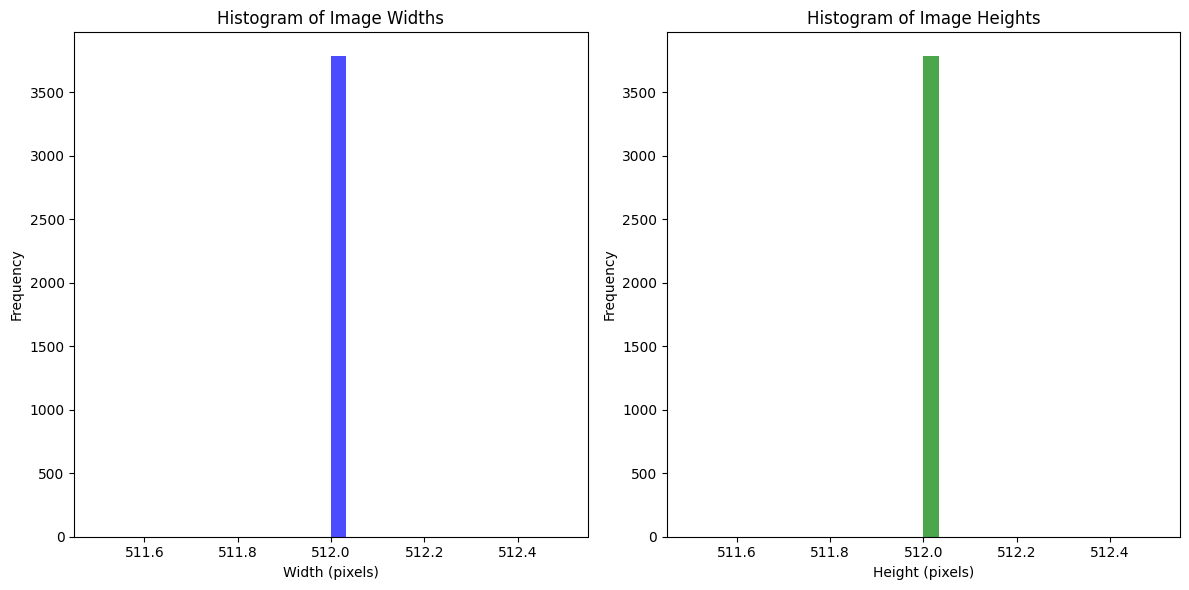

In [6]:
########### Print out the lists to verify ###########
print("Total files:",  len(X_train + X_val+X_test))
print("\nTraining Images:", len(X_train))
print("Training Labels:", len(y_train))
print("\nValidation Images:", len(X_val))
print("Validation Labels:", len(y_val))
print("\nTesting Images:", len(X_test))
print("Testing Labels:", len(y_test))

########## Create histograms for widths and heights ##########
plt.figure(figsize=(12, 6))

# Histogram for widths
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Histogram for heights
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='green', alpha=0.7)
plt.title('Histogram of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

######### Create a DataFrame from the lists #########
image_names = X_train + X_val + X_test
labels = y_train + y_val + y_test
data_splits_combined = ['train'] * len(X_train) + ['val'] * len(X_val) + ['test'] * len(X_test)
file_paths = X_train_path + X_val_path + X_test_path

In [7]:
# Create the DataFrame and shuffle it
df = pd.DataFrame({
    'image_name': image_names,
    'file_path': file_paths,
    'label': labels,
    'split': data_splits_combined
}).sample(frac=1, random_state=42).reset_index(drop=True)

The images are of standard dimensions of 512x512 pixels. This makes is easier to use certain Neural Network configurations.

In [8]:
df.head()

,image_name,file_path,label,split
0,20230622_153955_unsharp_clahe_augmented_1.png,/kaggle/input/guava-disease-dataset/GuavaDisea...,1,train
1,20230622_153613_unsharp_clahe_augmented_1.png,/kaggle/input/guava-disease-dataset/GuavaDisea...,1,val
2,20230622_153652_unsharp_clahe_augmented_7.png,/kaggle/input/guava-disease-dataset/GuavaDisea...,1,train
3,115_unsharp_clahe_augmented_6.png,/kaggle/input/guava-disease-dataset/GuavaDisea...,0,train
4,135_unsharp_clahe_augmented_3.png,/kaggle/input/guava-disease-dataset/GuavaDisea...,0,train


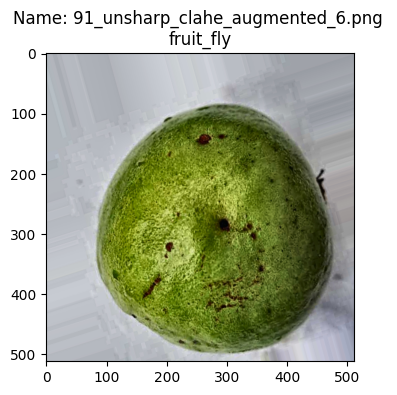

In [9]:
CLASS_NAMES= list(diseases.keys())

idx = np.random.randint(0, df.shape[0] )
#idx=0
sample_label = df['label'][idx]
sample_image = df['image_name'][idx]
sample_path = df['file_path'][idx]


plt.figure(figsize = (4,4))
plt.title('Name: {} \n{}'.format(sample_image, CLASS_NAMES[sample_label]))
img = Image.open(sample_path)
plt.imshow(img);

In [10]:
type(img)

PIL.PngImagePlugin.PngImageFile

In [11]:
# Code sample to convert a PNG image to a Tensor
import tensorflow as tf
tf.image.decode_png(tf.convert_to_tensor(tf.io.read_file(sample_path)))

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[176, 182, 188],
        [176, 182, 188],
        [176, 182, 188],
        ...,
        [160, 162, 169],
        [161, 162, 169],
        [161, 162, 169]],

       [[176, 182, 188],
        [176, 182, 188],
        [176, 182, 188],
        ...,
        [161, 162, 169],
        [161, 162, 169],
        [159, 161, 168]],

       [[176, 182, 188],
        [176, 182, 188],
        [176, 182, 188],
        ...,
        [156, 159, 166],
        [154, 157, 164],
        [153, 157, 164]],

       ...,

       [[181, 185, 192],
        [181, 185, 192],
        [181, 185, 192],
        ...,
        [160, 166, 186],
        [160, 166, 186],
        [163, 169, 189]],

       [[181, 185, 192],
        [181, 185, 192],
        [181, 185, 192],
        ...,
        [160, 166, 186],
        [160, 166, 186],
        [162, 168, 188]],

       [[181, 185, 192],
        [181, 185, 192],
        [181, 185, 192],
        ...,
        [160, 166, 18

In [12]:
%%capture
import keras

# For model building
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model, Sequential

# Hyperparameter modules
from keras.utils import to_categorical
from keras.optimizers import Adam, Adamax, RMSprop, Adagrad, SGD
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from keras.regularizers import L1, L2
from sklearn.metrics import classification_report, confusion_matrix

# Modules for Hyperparameter Tuning
import kerastuner as kt
from kerastuner import HyperModel, tuners
from kerastuner.tuners import BayesianOptimization
from hyperopt import STATUS_OK, fmin, hp, tpe, Trials, space_eval

1. **Use tf.data.Dataset for Efficient Data Loading**
Convert your DataFrame into a TensorFlow dataset using the from_tensor_slices method. This allows you to efficiently handle the file paths and labels.
2. **Load and Preprocess Images**
Define a function to load and preprocess images. This function will read images from disk, resize them if necessary, and normalize pixel values.
3. **Apply Mapping and Parallelism**
Use the map method to apply the preprocessing function to each element in the dataset. Utilize num_parallel_calls=tf.data.AUTOTUNE for automatic parallelism.
4. **Batching and Prefetching**
Batch the data and use prefetching to overlap data loading with model training.

In [13]:
######### Split the dataset first and then create a Tensorflow Dataset #########
train_paths = df[df['split']== 'train']['file_path'].values
train_labels = df[df['split']== 'train']['label'].values

test_paths = df[df['split']== 'test']['file_path'].values
test_labels = df[df['split']== 'test']['label'].values

val_paths = df[df['split']== 'val']['file_path'].values
val_labels = df[df['split']== 'val']['label'].values

In [14]:
'''Function for I/O operations'''
def load_and_preprocess_image(file_path, label):
    '''
    Loads and preprocesses the images using the file-paths provides
    Returns: Normalized np.array 
    '''
    image = tf.io.read_file(file_path)  # Read the image file
    image = tf.convert_to_tensor(image)
    image = tf.image.decode_png(image, channels=3)  # Decode PNG image
    image = tf.image.resize(image, [512, 512])  # Resize to desired dimensions
    image /= 255.0  # Normalize pixel values to [0, 1]
    return image, label



######### Create a TensorFlow dataset from the DataFrame #########
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_ds =  tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
val_ds =  tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

## Apply the load_and_preprocess_image function to the dataset: Mapping and Parallelism ##
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

## Batch the data, Prefetch and cache for better performance ##
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()

######## Implementing class weights for an imbalanced dataset ########

from sklearn.utils.class_weight import compute_class_weight
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(train_labels),
                                     y=train_labels)
# Create a dictionary mapping class labels to their corresponding weights
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.8169753086419753, 1: 0.9611474219317356, 2: 1.359527478171546}


In [19]:
from tensorflow.keras import layers, models

## Define a simple CNN model for multi-class classification
model = models.Sequential([
    layers.Input(shape=(512, 512, 3)),  # Input layer specifying the input shape
    layers.Conv2D(32, (3, 3), activation='relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # Output layer with softmax for three classes
])

# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    min_delta=10e-3,      
    patience=5,           
    verbose=1,           
    restore_best_weights=True  )

model_checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',  
    monitor='val_loss',          
    save_best_only=True,        
    verbose=1                   
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.2,           
    patience=5,           
    verbose=1,              
    cooldown=0,           
    min_lr=10e-5        
)

## Compile the model using sparse categorical cross-entropy loss
model.compile(optimizer='adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the model using the dataset
history = model.fit(train_ds, epochs=30, # class_weight=class_weight_dict, 
                    validation_data = val_ds, 
                    callbacks=[early_stopping_callback, 
                               model_checkpoint_callback,
                              reduce_lr_callback]) 

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.4503 - loss: 23.5638
Epoch 1: val_loss improved from inf to 0.35679, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 25s 279ms/step - accuracy: 0.4521 - loss: 23.3747 - val_accuracy: 0.8715 - val_loss: 0.3568 - learning_rate: 0.0010
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8903 - loss: 0.3258
Epoch 2: val_loss improved from 0.35679 to 0.30839, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 23s 279ms/step - accuracy: 0.8905 - loss: 0.3252 - val_accuracy: 0.8901 - val_loss: 0.3084 - learning_rate: 0.0010
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9349 - loss: 0.1805
Epoch 3: val_loss did not improve from 0.30839
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.9350 - loss: 0.1803 - val_accuracy: 0.8278 - val_loss: 0.3841 - learning_rate: 0.0010
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9697 - loss: 0.0927
Epoch 4: val_lo

In [20]:
def plot_performance(history,
                     xlims_loss = False, ylims_loss = False,
                     xlims_acc = False, ylims_acc = False,
                     loss_incr = 0.1, acc_incr=0.1,
                     xticks_loss = list(), yticks_loss = list(),
                     xticks_acc = list(), yticks_acc = list(),
                     title = str
                    ):
    
    training_loss = history.history['loss']
    val_loss = history.history['val_loss']
    training_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(training_loss,'b-', label = 'Training Loss')
    plt.plot(val_loss, 'r-', label = 'Validation Loss')
    
    # To modify axes ticks to accomodate large loss values
    if xlims_loss:
        plt.xticks(np.arange(*xticks_loss, loss_incr))
    if ylims_loss:
        plt.yticks(np.arange(*yticks_loss, loss_incr))

    plt.legend()
    plt.title('Loss')

    plt.subplot(1,2,2)
    plt.plot(training_acc,'b-', label = 'Training Accuracy')
    plt.plot(val_acc, 'r-', label = 'Validation Accuracy')
    
    # To modify axes ticks to accomodate low accuracy values
    if xlims_acc:
        plt.xticks(np.arange(*xticks_acc, acc_incr))
    if ylims_acc:
        plt.yticks(np.arange(*yticks_acc, acc_incr))

    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()
    plt.suptitle(title)
    plt.savefig(f'{title}.jpg')
    plt.show();


def cl_report(model, X_test = test_ds, y_test = test_labels):
    y_preds = model.predict(X_test)
    
    y_pred_classes = np.argmax(y_preds, axis=1)
    y_test_classes = np.argmax(y_test, axis =1)


    report = classification_report(y_test_classes, y_pred_classes)
    confusion_mx = confusion_matrix(y_test_classes, y_pred_classes)
    return (report), confusion_mx

def confusionmx_heatmap(confusion_matrix, title=str, tick_size = 10, annot_size=14, 
             annot_kws=8, cbar=False, normalize = bool, fmt = '.1f', c_mx = False ):
    
    if normalize == True:
        confusion_matrix = confusion_matrix/100
    plt.figure(figsize=(3,3))
    heatmap = sns.heatmap(confusion_matrix, 
                          fmt = fmt, annot = True, 
                          annot_kws = {'size': annot_kws}, 
                          cmap='BrBG', xticklabels = CLASS_NAMES, yticklabels = CLASS_NAMES)
    
    plt.xticks(rotation=80, fontsize= tick_size)
    plt.yticks( rotation=45, fontsize= tick_size)

    heatmap.set_title(title, fontdict={'fontsize':annot_size}, pad=12)
    plt.tight_layout()
    plt.savefig(f'{title}.jpg')
    plt.show();
    
    if c_mx:
        return confusion_matrix

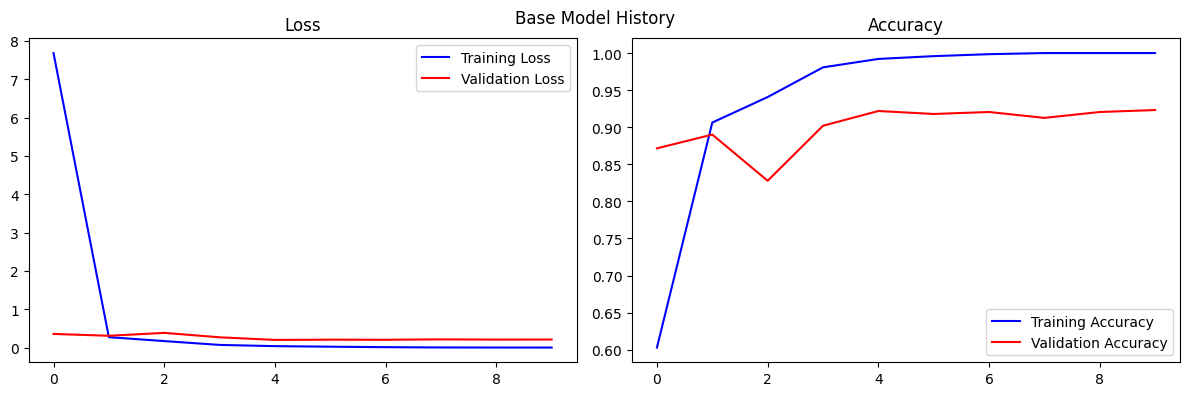

In [21]:
plot_performance(history, title='Base Model History')

In [23]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('/kaggle/working/best_model.keras')

loss, accuracy = best_model.evaluate(test_ds)
loss, accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9111 - loss: 0.2237


(0.23042209446430206, 0.9188481569290161)

In [24]:
print(cl_report(best_model, test_ds, to_categorical(test_labels))[0])

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       156
           1       0.91      0.89      0.90       132
           2       0.91      0.90      0.91        94

    accuracy                           0.92       382
   macro avg       0.92      0.92      0.92       382
weighted avg       0.92      0.92      0.92       382



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


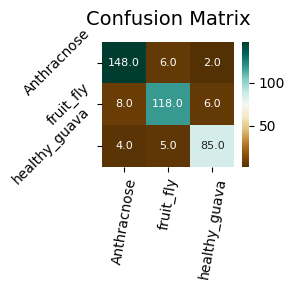

In [25]:
c_mx = cl_report(model, test_ds, to_categorical(test_labels))[1]

confusionmx_heatmap(c_mx, title = 'Confusion Matrix', normalize = 0)

In [26]:
# Assuming 'model' is your trained model and 'val_ds' is your validation dataset
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1).numpy()  # Get the predicted class indices
true_labels = test_ds.map(lambda x, y: y) # Extract true labels


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


In [27]:
# Extract true labels from the test dataset
true_labels = []
for _, labels in test_ds:
    true_labels.extend(labels.numpy())  # Collect true labels into a list

true_labels = np.array(true_labels)  # Convert to NumPy array
true_labels

array([1, 1, 1, 2, 0, 0, 2, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 0, 1,
       2, 0, 0, 2, 0, 0, 2, 1, 2, 1, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2,
       1, 1, 0, 2, 1, 1, 1, 2, 1, 0, 2, 0, 2, 0, 0, 2, 1, 1, 1, 1, 2, 0,
       0, 0, 0, 2, 1, 0, 2, 2, 0, 1, 1, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 0,
       1, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 1, 0, 1, 2, 2, 0, 0, 0, 1, 2,
       1, 2, 2, 1, 2, 2, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0,
       2, 2, 0, 2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 1, 1, 2, 0, 2,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       2, 0, 0, 0, 1, 1, 0, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2, 2, 0, 0, 1, 0,
       0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 1, 0, 2, 1, 0, 0, 2, 2, 0, 0, 2, 0,
       1, 1, 1, 1, 2, 0, 1, 2, 0, 2, 1, 1, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0,
       2, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1,
       1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2, 1, 0, 1,

In [28]:
# Identify indices of accurate and inaccurate predictions
accurate_indices = {}
inaccurate_indices = {}

for i in range(len(true_labels)):
    true_label = true_labels[i]
    predicted_label = predicted_labels[i]

    if true_label not in accurate_indices:
        accurate_indices[true_label] = []
        inaccurate_indices[true_label] = []

    if true_label == predicted_label:
        accurate_indices[true_label].append(i)  # Store index of correct prediction
    else:
        inaccurate_indices[true_label].append(i)  # Store index of incorrect prediction


In [29]:
accurate_indices 
inaccurate_indices 


{1: [8, 32, 88, 116, 125, 149, 160, 184, 249, 254, 259, 263, 290, 361],
 2: [3, 30, 43, 93, 95, 245, 319, 344, 378],
 0: [17, 101, 144, 152, 161, 316, 359, 364]}